# Part 1 Data Gathering


In [ ]:
# Install the required packages
! pip install beautifulsoup4
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bs4 import BeautifulSoup as bs 
import requests
import yfinance as yf
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import warnings

## Get Stocks daily OCHLV data

- S&P get list of stocks from wikipedia 
- Download data from yfinance
  

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [ ]:
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
all_stocks = [x.replace('\n','') for x in tickers] # remove the new line character

## Download data from yfinance

In [ ]:
all_df = pd.DataFrame()
start_date = '2018-07-01'
end_date = '2022-06-01'
fname_string = 'all_stocks_' + start_date + '_' + end_date + '.csv'


for tkr in all_stocks:
  single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date,auto_adjust=True)
  single_stock_pd['stock'] = tkr
  all_df = all_df.append(single_stock_pd)

all_df.to_csv(fname_string)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Read Locally and skip the download

In [ ]:
all_df = pd.read_csv(fname_string)

In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)

<AxesSubplot:>

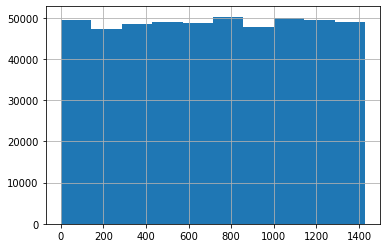

In [ ]:
all_df['t0'].hist()

# Calculate Features & Target values for all stocks


In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)

# Filter the DataFrame to keep only the stocks that were traded on all trading days
counts = all_df['stock'].value_counts()
all_days_stocks = counts[counts == counts.max()].index.tolist()
all_df = all_df[all_df['stock'].isin(all_days_stocks)]

# Split the data to segments (6 months features, 3 months labelling)
FEATURES_SIZE = 180 
LABELLING_SIZE = 90

start_train_features_day = 0
end_train_features_day = start_train_features_day + FEATURES_SIZE
start_train_labelling_day = end_train_features_day + 1 
end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE
all_features_train_df = all_df[(all_df['t0'] >= start_train_features_day)&(all_df['t0'] < end_train_features_day)]
all_labelling_train_df = all_df[(all_df['t0'] >= start_train_labelling_day)&(all_df['t0'] < end_train_labelling_day)]



In [ ]:
print(f'start_date:{start_train_features_day} , end_ft_day: {end_train_features_day}')

start_date:0 , end_ft_day: 180


In [ ]:
def calculate_returns(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']

<AxesSubplot:>

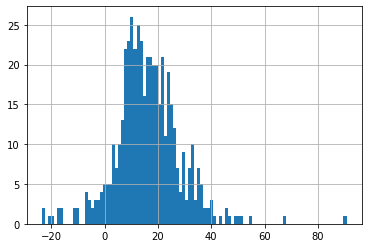

In [ ]:
#Calculating the train returns in the labelling 3 months
train_returns = all_labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x))
train_returns.hist(bins=100)

In [ ]:
# Make sure that the features are 6 months
print(all_features_train_df['t0'].max() - all_features_train_df['t0'].min())
# Make sure that the labelling is 90 days
print(all_labelling_train_df['t0'].max() - all_labelling_train_df['t0'].min())


179.0
88.0


In [ ]:
# Splitting the stocks to good and bad stocks based on greater or less then the median return
threshold = train_returns.median()
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index

### Calculating features for the train features months

In [ ]:
# average change during the day
def calculate_high_to_low(x):
  return 100*(x['High'] - x['Low'])/x['Open']
high_to_low_df = all_features_train_df.groupby('stock').apply(calculate_high_to_low).reset_index()

In [ ]:
# Calculating the median of how much the stock has moved during the day
analysis_df = high_to_low_df.groupby('stock').median().reset_index().drop('level_1', axis =1)
analysis_df.columns = ['stock', 'median high to low']
analysis_df['change in price'] = train_returns.values
# Adding a binary target column for our classification based on the labelling
analysis_df.loc[analysis_df['stock'].isin(good),'target'] = 1
analysis_df['target'].fillna(0,inplace=True)
analysis_df

,stock,median high to low,change in price,target
0,A,1.778113,21.163696,1.0
1,AAL,3.351053,-0.758539,0.0
2,AAP,1.995692,9.319022,0.0
3,AAPL,2.061855,20.333478,1.0
4,ABBV,2.361385,-10.940559,0.0
...,...,...,...,...
486,YUM,1.336425,9.225094,0.0
487,ZBH,1.997741,24.167322,1.0
488,ZBRA,2.688361,33.399114,1.0
489,ZION,2.197801,12.829610,0.0


**Chosen Feature:**

**Median high to low** - the median of the daily high - low, it can indicate how stable the stock is.


correlation: 0.2557578280417361
linear regression:
slope: 5.22010202482491
intercept: 5.512830620644616
r-squared: 0.06541206660462627


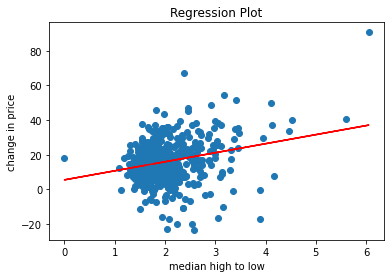

In [ ]:
corr = analysis_df['median high to low'].corr(analysis_df['change in price'])
print("correlation:", corr)

slope, intercept, r_value, p_value, std_err = linregress(analysis_df['median high to low'], analysis_df['change in price'])
print("linear regression:")
print("slope:", slope)
print("intercept:", intercept)
print("r-squared:", r_value**2)
plt.scatter(analysis_df['median high to low'], analysis_df['change in price'])

# Plot the regression line
x = analysis_df['median high to low']
y = slope*x + intercept
plt.plot(x, y, color='r')

# Add labels and title
plt.xlabel('median high to low')
plt.ylabel('change in price')
plt.title('Regression Plot')
# Show the plot
plt.show()

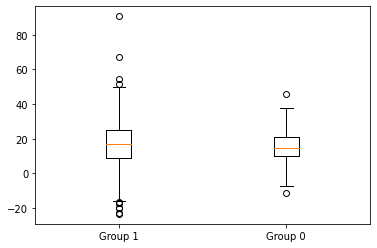

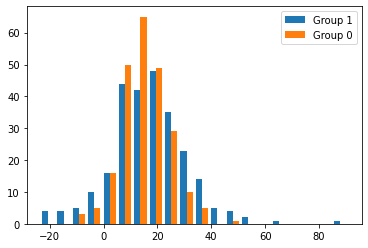

Group 1 mean:  17.16383159661539
Group 1 median:  16.82641199929448
Group 1 20% percentile:  7.456830983962064
Group 0 mean:  15.120723613420914
Group 0 median:  14.452638389998937
Group 0 20% percentile:  8.7318539215742
Group 1 Skewness:  0.4180592526654256
Group 1 Kurtosis:  2.751354510436931
Group 0 Skewness:  0.13216865302269487
Group 0 Kurtosis:  0.6474033914830333


In [ ]:
df1 = analysis_df[analysis_df['median high to low']>1.9]
df0 = analysis_df[analysis_df['median high to low']<=1.9]

plt.boxplot([df1['change in price'], df0['change in price']], labels=['Group 1', 'Group 0'])
plt.show()

# Use histogram to visualize the distribution of the two groups
plt.hist([df1['change in price'], df0['change in price']], bins=20, label=['Group 1', 'Group 0'])
plt.legend()
plt.show()

# Calculate mean, median, 20% percentiles for each group
print("Group 1 mean: ", df1['change in price'].mean())
print("Group 1 median: ", df1['change in price'].median())
print("Group 1 20% percentile: ", df1['change in price'].quantile(0.2))

print("Group 0 mean: ", df0['change in price'].mean())
print("Group 0 median: ", df0['change in price'].median())
print("Group 0 20% percentile: ", df0['change in price'].quantile(0.2))

# Use skew and kurtosis to check the shape of the distributions
print("Group 1 Skewness: ", df1['change in price'].skew())
print("Group 1 Kurtosis: ", df1['change in price'].kurtosis())
print("Group 0 Skewness: ", df0['change in price'].skew())
print("Group 0 Kurtosis: ", df0['change in price'].kurtosis())

In [ ]:
true_positive = len(df1[df1['target'] == 1])
true_negative = len(df0[df0['target'] == 0])
false_positive = len(df1[df1['target'] == 0])
false_negative = len(df0[df0['target'] == 1])
print(
f'''
Train results:
  True positive: {true_positive},
  True negative: {true_negative},
  False positive: {false_positive},
  False negative: {false_negative}
''')

Precision = true_positive / (true_positive + false_positive)
Recall = true_positive / (true_positive + false_negative)
print("Precision:", Precision)
print("Recall:", Recall)


Train results:
  True positive: 139,
  True negative: 127,
  False positive: 119,
  False negative: 106

Precision: 0.5387596899224806
Recall: 0.5673469387755102


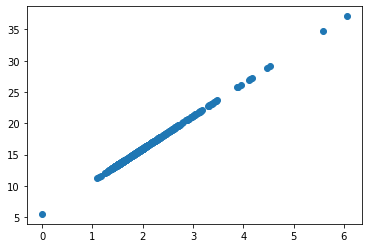

In [ ]:
plt.scatter(analysis_df['median high to low'], y)
# The threshold chosen is 2.5

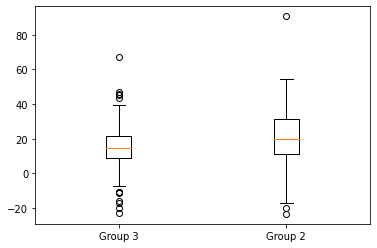

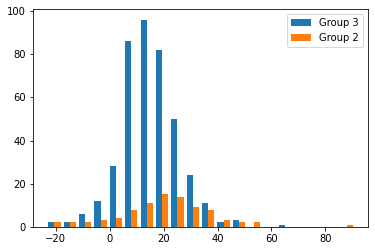

Group 3 mean:  15.280934043241386
Group 3 median:  14.720847878054586
Group 3 20% percentile:  8.001505413098458
Group 2 mean:  20.495568213268395
Group 2 median:  20.096487659602303
Group 2 20% percentile:  8.426967797112601
Group 3 Skewness:  0.1744026509598174
Group 3 Kurtosis:  1.9916005161420438
Group 2 Skewness:  0.34632327466379625
Group 2 Kurtosis:  2.5784814797114484


In [ ]:
df2 = analysis_df[analysis_df['median high to low']>2.5]
df3 = analysis_df[analysis_df['median high to low']<=2.5]

plt.boxplot([df3['change in price'], df2['change in price']], labels=['Group 3', 'Group 2'])
plt.show()

# Use histogram to visualize the distribution of the two groups
plt.hist([df3['change in price'], df2['change in price']], bins=20, label=['Group 3', 'Group 2'])
plt.legend()
plt.show()

# Calculate mean, median, 20% percentiles for each group
print("Group 3 mean: ", df3['change in price'].mean())
print("Group 3 median: ", df3['change in price'].median())
print("Group 3 20% percentile: ", df3['change in price'].quantile(0.2))
print("Group 2 mean: ", df2['change in price'].mean())
print("Group 2 median: ", df2['change in price'].median())
print("Group 2 20% percentile: ", df2['change in price'].quantile(0.2))

# Use skew and kurtosis to check the shape of the distributions
print("Group 3 Skewness: ", df3['change in price'].skew())
print("Group 3 Kurtosis: ", df3['change in price'].kurtosis())
print("Group 2 Skewness: ", df2['change in price'].skew())
print("Group 2 Kurtosis: ", df2['change in price'].kurtosis())

In [ ]:
true_positive = len(df3[df3['target'] == 1])
true_negative = len(df2[df2['target'] == 0])
false_positive = len(df3[df3['target'] == 0])
false_negative = len(df2[df2['target'] == 1])
print(
f'''
Train results:
  True positive: {true_positive},
  True negative: {true_negative},
  False positive: {false_positive},
  False negative: {false_negative}
''')

Precision = true_positive / (true_positive + false_positive)
Recall = true_positive / (true_positive + false_negative)
print("Precision:", Precision)
print("Recall:", Recall)


Train results:
  True positive: 187,
  True negative: 28,
  False positive: 218,
  False negative: 58

Precision: 0.4617283950617284
Recall: 0.763265306122449


In summary, our goal was to predict stocks that would have high performance in the next 3 months. We found that linear regression alone was not effective in predicting the performance based on the feature values. Specifically, it did not accurately predict the value of the change. However, we did observe that linear regression could still indicate a trend. By setting a threshold, we found that the feature values were useful in generally predicting which stocks would perform better.

# Training the model

In [ ]:
features_df = all_features_train_df.copy()
features_df['month_index'] = (features_df['t0'] / 30).astype(int)

# monthly price feature
def calculate_price_change(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']

# volume feature
def calculate_volume_change(x):
  if x.iloc[0]['Volume'] == 0:
    return 0
  return abs(100*(x.iloc[-1]['Volume'] - x.iloc[0]['Volume'])/x.iloc[0]['Volume'])

# average daily change
def calculate_daily_returns(x):
  return 100*(x['Close'] - x['Open'])/x['Open']

# average change during the day
def calculate_high_to_low(x):
  return 100*(x['High'] - x['Low'])/x['Open']

# daily returns rank
def daily_returns_rank(x):
  return 1 if x['Close'] > x['Open'] else -1

# monthly price rank feature
def calculate_price_change(x):
  if x.iloc[-1]['Close'] - x.iloc[0]['Open'] < 0:
    return -1
  return 1

In [ ]:
monthly_features_df = features_df.groupby(['stock','month_index']).apply(calculate_price_change).reset_index()
monthly_volume_df = features_df.groupby(['stock','month_index']).apply(calculate_volume_change).reset_index()
daily_change_df = features_df.groupby('stock').apply(calculate_daily_returns).reset_index()
high_to_low_df = features_df.groupby('stock').apply(calculate_high_to_low).reset_index()
features_df["daily rank"] = features_df.apply(daily_returns_rank, axis = 1)
monthly_rank_df = features_df.groupby(['stock','month_index']).apply(calculate_price_change).reset_index()
# Difference in volume
group_by_stock = features_df.groupby('stock')
max_volume = group_by_stock["Volume"].max()
min_volume = group_by_stock["Volume"].min()
volume_range = (max_volume-min_volume)/max_volume*100
# Monthly high to low difference
group_by_df = features_df.groupby(['stock','month_index'])
max_high = group_by_df["High"].max()
lowest_low = group_by_df["Low"].min()
hightolow = ((max_high-lowest_low)/max_high*100).groupby('stock').max()
# Monthly opens difference
max_open = abs(group_by_df["Open"].max())
lowest_open = abs(group_by_df["Open"].min())
open_dif = ((max_open-lowest_open)/max_open*100).groupby('stock').max()
# Monthly close difference
max_close = abs(group_by_df["Close"].max())
min_close = abs(group_by_df["Close"].min())
close_dif = ((max_close-min_close)/max_close*100).groupby('stock').max()
# Calculating each stock best and worst monthly return to be used as our features
worst_monthly_return = monthly_features_df.groupby('stock').min().reset_index()
best_monthly_return = monthly_features_df.groupby('stock').max().reset_index()
train_df = best_monthly_return[['stock',0]]
train_df['worst'] = worst_monthly_return[0]
train_df.columns = ['stock', 'best_month', 'worst_month'] 
# Calculating each stock max change in volume
max_positive_monthly_volume = monthly_volume_df.groupby('stock').max().reset_index()
train_df["highest change volume"] = max_positive_monthly_volume[0]
# Calculating median daily change
median_change = daily_change_df.groupby('stock').median().reset_index()
train_df["median"] = median_change[0]
# Calculating the median of how much the stock has moved during the day
median_high_to_low = high_to_low_df.groupby('stock').median().reset_index()
train_df["median high to low"] = median_high_to_low[0]
# Calaculating the rank for each stock according to when it finished the day higher or lower
df_sum = features_df.groupby('stock')['daily rank'].sum()
train_df = pd.merge(train_df, df_sum, on ='stock', how ='left')
# Calaculating the rank for each stock according to when it finished the month higher or lower
df_sum = monthly_rank_df.groupby('stock').sum()
train_df = pd.merge(train_df, df_sum[0], on ='stock', how ='left')
# Calaculating the precentage of change from higest to lowest volume
train_df = pd.merge(train_df, volume_range, on ='stock', how ='left')
# Calaculating the precentage of change from higest high to lowest low
train_df["monthly high to low"] = hightolow.values
# Calaculating the monthly open difference
train_df["open dif."] = open_dif.values
# Calaculating the monthly close difference
train_df["close dif."] = close_dif.values
train_df.columns = ['stock', 'best_month', 'worst_month', 'highest change volume', 'median', 'median high to low', 'daily rank', 'monthly rank', "volume range", "monthly high to low", "open dif.", "close dif."]
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
# Adding a binary target column for our classification based on the labelling
train_df.loc[train_df['stock'].isin(good),'target'] = 1
train_df['target'].fillna(0,inplace=True)
train_df['target'].value_counts()
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
x = train_df.drop(columns=['target','stock'], axis = 1)
clf.fit(x, train_df['target'])
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
x = train_df.drop(columns=['target','stock'], axis = 1)
clf.fit(x, train_df['target'])

RandomForestClassifier(max_depth=5, random_state=0)

# Testing the model
- From the last day of the label dataset (180+90+start day)
- Start day: 270
- 12 cycles


In [ ]:
def test(i):
  features_df = all_features_test_df.copy(deep=True)
  features_df = features_df.assign(month_index=(features_df['t0'] / 30).astype(int))
  monthly_features_df = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
  monthly_volume_df = features_df.groupby(['stock','month_index']).apply(calculate_volume_change).reset_index()
  daily_change_df = features_df.groupby('stock').apply(calculate_daily_returns).reset_index()
  high_to_low_df = features_df.groupby('stock').apply(calculate_high_to_low).reset_index()
  monthly_rank_df = features_df.groupby(['stock','month_index']).apply(calculate_price_change).reset_index()
  worst_monthly_return = monthly_features_df.groupby('stock').min().reset_index()
  best_monthly_return = monthly_features_df.groupby('stock').max().reset_index()
  test_df = best_monthly_return[['stock',0]]
  test_df['worst'] = worst_monthly_return[0]
  test_df.columns = ['stock', 'best_month', 'worst_month']
  # Calculating each stock max change in volume
  max_positive_monthly_volume = monthly_volume_df.groupby('stock').max().reset_index()
  test_df["highest change volume"] = max_positive_monthly_volume[0]
  # Calculating median daily change
  median_change = daily_change_df.groupby('stock').median().reset_index()
  test_df["median"] = median_change[0]
  # Calculating the median of how much the stock has moved during the day
  median_high_to_low = high_to_low_df.groupby('stock').median().reset_index()
  test_df["median high to low"] = median_high_to_low[0]
  # Calaculating the rank for each stock according to when it finished the day higher or lower
  features_df["daily rank"] = features_df.apply(daily_returns_rank, axis = 1)
  df_sum = features_df.groupby('stock')['daily rank'].sum()
  test_df = pd.merge(test_df, df_sum, on ='stock', how ='left')
  # Calaculating the rank for each stock according to when it finished the month higher or lower
  monthly_rank_df = features_df.groupby(['stock','month_index']).apply(calculate_price_change).reset_index()
  df_msum = monthly_rank_df.groupby('stock').sum()
  test_df = pd.merge(test_df, df_msum[0], on ='stock', how ='left')
  # Calaculating the precentage of change from higest to lowest volume
  group_by_stock = features_df.groupby('stock')
  max_volume = group_by_stock["Volume"].max()
  min_volume = group_by_stock["Volume"].min()
  volume_range = (max_volume-min_volume)/max_volume*100
  test_df = pd.merge(test_df, volume_range, on ='stock', how ='left')
  # Calaculating the precentage of change from higest high to lowest low
  group_by_df = features_df.groupby(['stock','month_index'])
  max_high = group_by_df["High"].max()
  lowest_low = group_by_df["Low"].min()
  hightolow = ((max_high-lowest_low)/max_high*100).groupby('stock').max()
  test_df["monthly high to low"] = hightolow.values
  # Calaculating the monthly open difference
  max_open = abs(group_by_df["Open"].max())
  lowest_open = abs(group_by_df["Open"].min())
  open_dif = ((max_open-lowest_open)/max_open*100).groupby('stock').max()
  test_df["open dif."] = open_dif.values
  # Calaculating the monthly close difference
  max_close = abs(group_by_df["Close"].max())
  min_close = abs(group_by_df["Close"].min())
  close_dif = ((max_close-min_close)/max_close*100).groupby('stock').max()
  test_df["close dif."] = close_dif.values
  test_df.columns = ['stock', 'best_month', 'worst_month', 'highest change volume', 'median', 'median high to low', 'daily rank', 'monthly rank', "volume range", "monthly high to low", "open dif.", "close dif."]
  test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
  test_df.dropna(inplace=True)
  test_df['predicted_y'] = clf.predict(test_df.drop(columns=['stock'], axis = 1))
  prediction=test_df['predicted_y']
  test_df['predicted_y'].value_counts()
  test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
  label_threshold = test_returns.median()
  good_test = test_returns[test_returns > label_threshold].index
  test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
  test_df['actual_y'].fillna(0,inplace=True)
  test_df['actual_y'].value_counts()
  # Count the number of occurrences of each predicted label in the test data
  test_df.loc[:, 'predicted_y'].value_counts()
  test_returns = all_labelling_test_df.groupby('stock').apply(lambda x: calculate_returns(x))
  # Identify the stocks with returns above the median threshold
  label_threshold = test_returns.median()
  good_test = test_returns[test_returns > label_threshold].index
  # Assign a label of 1 to the actual_y column for the identified "good" stocks
  test_df.loc[test_df['stock'].isin(good_test), 'actual_y'] = 1
  test_df['actual_y'].fillna(0, inplace=True)
  # Count the number of occurrences of each actual label in the test data
  test_df['actual_y'].value_counts()
  
  if i<13:
    # Confusion matrix, precision, and recall
    true_positive = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==True)])
    true_negative = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==False)])
    false_positive = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==True)])
    false_negative = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==False)])
    print(
    f'''
    True positive: {true_positive},
    True negative: {true_negative},
    False positive: {false_positive},
    False negative: {false_negative}
    ''')
    matrix = confusion_matrix(test_df['actual_y'], test_df['predicted_y'])
    title = f"Confusion Matrix - Period {i}"
    disp = ConfusionMatrixDisplay(matrix, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.viridis, xticks_rotation='horizontal')
    plt.title(title, fontsize=14)
    plt.show()
  
  return test_df





    True positive: 53,
    True negative: 182,
    False positive: 64,
    False negative: 192
    


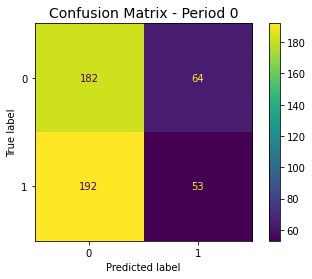


    True positive: 56,
    True negative: 181,
    False positive: 65,
    False negative: 189
    


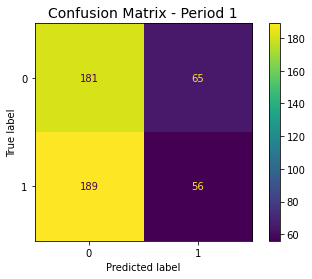


    True positive: 100,
    True negative: 189,
    False positive: 57,
    False negative: 145
    


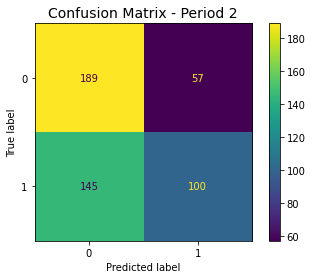


    True positive: 99,
    True negative: 186,
    False positive: 60,
    False negative: 146
    


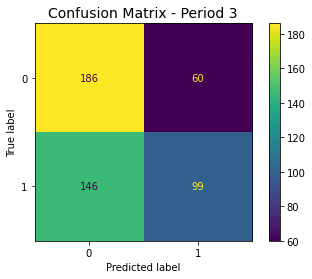


    True positive: 84,
    True negative: 184,
    False positive: 62,
    False negative: 161
    


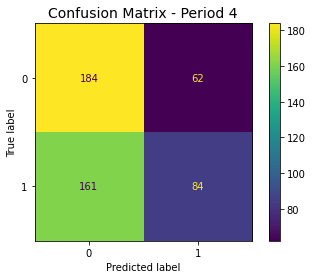


    True positive: 63,
    True negative: 145,
    False positive: 101,
    False negative: 182
    


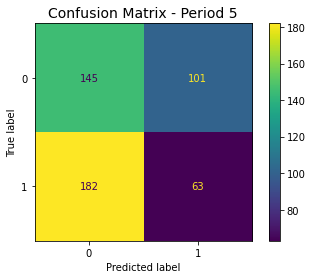


    True positive: 58,
    True negative: 142,
    False positive: 104,
    False negative: 187
    


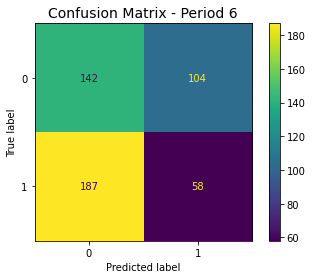


    True positive: 52,
    True negative: 147,
    False positive: 99,
    False negative: 193
    


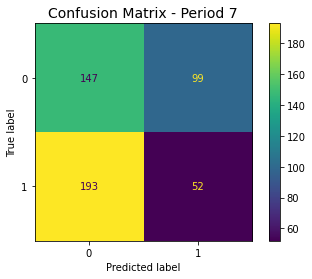


    True positive: 67,
    True negative: 167,
    False positive: 79,
    False negative: 178
    


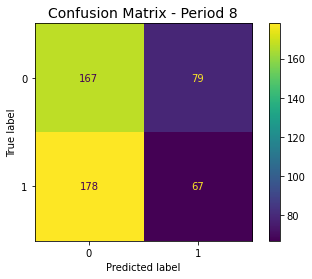


    True positive: 177,
    True negative: 57,
    False positive: 189,
    False negative: 68
    


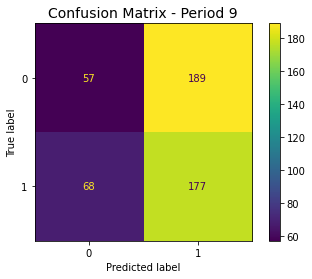


    True positive: 158,
    True negative: 70,
    False positive: 176,
    False negative: 87
    


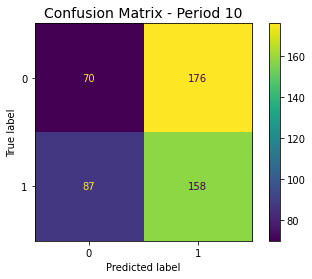


    True positive: 192,
    True negative: 54,
    False positive: 192,
    False negative: 53
    


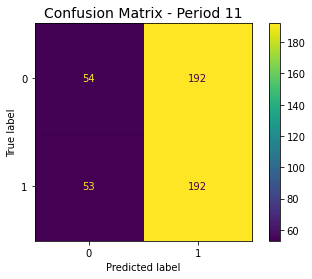

In [ ]:
for i in range (12):
  start_test_features_day = start_train_features_day + 180 + i*30
  end_test_features_day = start_test_features_day + FEATURES_SIZE
  start_test_labelling_day = end_test_features_day + 1 
  end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE                   
  all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]
  all_labelling_test_df = all_df[(all_df['t0'] >= start_test_labelling_day)&(all_df['t0'] < end_test_labelling_day)]
  test(i)

These are 12 different confusion matrices that describe the performance of an AI model over a period of time. Each matrix consists of four values: true positive, true negative, false positive, and false negative. The TP and TN values indicate the number of correct predictions made by the model, while the FP and FN values indicate the number of incorrect predictions made by the model.


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
i=36
start_test_features_day = start_train_features_day + 180 + i*30
end_test_features_day = start_test_features_day + FEATURES_SIZE
start_test_labelling_day = end_test_features_day + 1 
end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE                   
all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]
all_labelling_test_df = all_df[(all_df['t0'] >= start_test_labelling_day)&(all_df['t0'] < end_test_labelling_day)]
all_stockes=test(i)

In [ ]:
portfolio=all_stockes[all_stockes['predicted_y']==1.0]
all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]
snp_returns = all_features_test_df.groupby('stock').apply(lambda x: calculate_returns(x))
filtered_df = all_features_test_df[all_features_test_df['stock'].isin(portfolio['stock'])]
portfolio_returns = filtered_df.groupby('stock').apply(lambda x: calculate_returns(x))
# calculate excess returns
risk_free_rate = 0.03
snp_excess_returns = snp_returns - risk_free_rate
portfolio_excess_returns = portfolio_returns - risk_free_rate
# calculate standard deviation of returns
snp_std = np.std(snp_returns)
portfolio_std = np.std(portfolio_returns)
# Calculate the Sharpe ratio for the S&P 500
snp_sharpe = np.sqrt(FEATURES_SIZE) * (snp_excess_returns.mean() / snp_std)
# Calculate the Sharpe ratio for the portfolio
portfolio_sharpe = np.sqrt(FEATURES_SIZE) * (portfolio_excess_returns.mean() / portfolio_std)

print('S&P 500 Sharpe Ratio:', snp_sharpe)
print('Portfolio Sharpe Ratio:', portfolio_sharpe)


S&P 500 Sharpe Ratio: -2.2683884974431914
Portfolio Sharpe Ratio: -4.259628296322378


The Sharpe ratios for both the S&P 500 and the portfolio were negative, suggesting that the returns on the investment did not adequately compensate for the risk taken by the investor. While the portfolio did not perform as well as expected, the results can still provide insights for optimizing the portfolio and improving the risk-return profile in the future.